In [2]:
from bs4 import BeautifulSoup
from selenium import webdriver
import pandas as pd
import requests
import time
import re
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

In [68]:
newspapers = ['joongang', 'donga', 'hankyure','kyunghyang']
periods = ['pandemic', 'endemic']
political_map = {
    '한겨레':'진보', 
    '경향신문':'진보',
    '중앙일보':'보수',
    '동아일보':'보수'
}
en_to_ko_translate_map = {
    'joongang': '중앙일보',
    'donga': '동아일보',
    'hankyure': '한겨레',
    'kyunghyang': '경향신문',
    'pandemic': '팬데믹',
    'endemic': '엔데믹',
    'right': '보수',
    'left': '진보',
}
ko_to_en_translate_map = {v: k for k, v in en_to_ko_translate_map.items()}

# 1. 데이터 수집

In [69]:
columns_to_read = ['언론사', 'URL']
file_paths_by_period_map = {
    'pandemic': 'NewsResult_20221201-20221231.xlsx',
    'endemic': 'NewsResult_20230701-20230731.xlsx'
}

In [80]:
headers = {
                    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
                }
session = requests.Session()
session.headers.update(headers)

In [87]:
for period in periods:
    filepath = file_paths_by_period_map[period]
    df = pd.read_excel(filepath, usecols=columns_to_read)
    result_dict = df.groupby('언론사')['URL'].agg(list).to_dict()
    for newspaper in newspapers:
        newspaper_ko = en_to_ko_translate_map[newspaper]
        df = pd.DataFrame(result_dict[newspaper_ko], columns=['url'])
        text_list  = []
        for url in df['url']:
            r = requests.get(url)
            soup = BeautifulSoup(r.text, 'lxml')
            if newspaper == 'joongang':
                article_body = soup.find('div', attrs = {'id':'article_body'}).find_all('p')
                article_text = [elem.get_text() for elem in article_body]
                article_text = ' '.join(article_text)
            elif newspaper == 'hankyure':
                article_text = ' '.join(soup.find('div', attrs={'class':'article-text'}).text.split())
            elif newspaper == 'kyunghyang':
                headers = {
                    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
                }
                session = requests.Session()
                session.headers.update(headers)
                article_body = soup.find('div', attrs = {'class':'art_body'}).find_all('p')
                article_text = [elem.get_text() for elem in article_body]
                article_text = ' '.join(article_text)
            elif newspaper == 'donga':
                article_text = soup.find('div', attrs = {'id':'article_txt'}).text
            result = re.search(r"^(.*?)([a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}|$)", article_text, re.DOTALL)
            if result:
                txt_remove_email = result.group(1)
                text_list.append(txt_remove_email)
            else:
                text_list.append(article_text)
            time.sleep(1)
        df['result'] = text_list
        df.to_excel(f"{newspaper}_{period}.xlsx")


joongang
donga
hankyure
kyunghyang
joongang
donga
hankyure
kyunghyang


/opt/conda/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/opt/conda/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


# 2. 한글 전처리


In [3]:
from kiwipiepy import Kiwi
from kiwipiepy.utils import Stopwords
import re
from collections import Counter

In [4]:
kiwi = Kiwi()
stopwords_dict = Stopwords()

# 불용어 사용자 정의

customized_stopwords = ['올해', '지난해', '내년', '이후', '상반기', '하반기', '기자', '사진']
for word in customized_stopwords:
    stopwords_dict.add((word, 'NNG')) 
    
customized_stopwords = ['연합뉴스', '중앙일보', '동아일보', '한겨레', '경향신문']
for word in customized_stopwords:
    stopwords_dict.add((word, 'NNP'))

In [5]:
def list_to_string(media_list):
    media_string =' '.join(media_list) 
    return media_string

In [6]:
def preprocessing(media_string):
        
    filtered_content = re.sub(r'[^\s\w\d]', '', media_string)
    kiwi_tokens = kiwi.tokenize(filtered_content, stopwords = stopwords_dict) 
    noun_words = []
    for token in kiwi_tokens:
        if 'NN' in token.tag:
            noun_words.append(token.form)
        
    final_noun_words = []
    for word in noun_words:
        if len(word) > 1:
            final_noun_words.append(word)
        
    return final_noun_words

In [7]:
def get_words(counter_results):
    words = []
    for word, fre in counter_results:
        words.append(word)
    return words

In [8]:
def select_words(K, media_string):
    c = Counter(preprocessing(media_string))
    selected_words = get_words(c.most_common(K))
    return selected_words

In [70]:
total_list = []
from collections import defaultdict
political_result = defaultdict(lambda: defaultdict(list))

In [71]:
for newspaper in newspapers:
    for period in periods:
        newspaper_ko, period_ko = en_to_ko_translate_map[newspaper], en_to_ko_translate_map[period]
        df = pd.read_excel(f'{newspaper}_{period}.xlsx',index_col=0)
        text_list = df['result'].values.tolist()
        total_list.append([newspaper_ko, text_list, period_ko])
        political_result[political_map[newspaper_ko]][period_ko].extend(text_list)

In [72]:
for political_type, texts_by_period in political_result.items():
    for period, text in texts_by_period.items():
        total_list.append([political_type, text, period])

In [73]:
top_freq_result = []
for name, text_list, period in total_list:
    string_result = list_to_string(text_list)
    selected_result = select_words(10, string_result)
    top_freq_result.append([name, ', '.join(selected_result), period])

In [74]:
top_freq_result_df = pd.DataFrame(top_freq_result, columns=['name','top_freq','period'])
#top_freq_result_df

In [75]:
top_freq_pivot_result_df = top_freq_result_df.pivot(index='name',columns='period', values='top_freq')
top_freq_pivot_result_df

period                                           엔데믹  \
name                                                   
경향신문       코로나, 중국, 의원, 위원장, 초선, 증가, 발생, 질환, 이상, 감염병   
동아일보    코로나, 확진자, 의원, 바이러스, 마스크, 증가, 여객, 초선, 위원장, 접종   
보수       코로나, 증가, 마스크, 확진자, 병원, 북한, 중국, 유행, 바이러스, 의원   
중앙일보        코로나, 북한, 병원, 증가, 중국, 마스크, 저축, 가계, 유행, 교수   
진보         코로나, 중국, 위원장, 의원, 초선, 증가, 발생, 접종, 감염병, 의료   
한겨레         코로나, 백신, 정부, 격리, 학생, 급식, 제공, 의료, 소송, 간호사   

period                                         팬데믹  
name                                                
경향신문      코로나, 중국, 방역, 검사, 정책, 감염, 완화, 조치, 감염자, 당국  
동아일보    코로나, 중국, 확진자, 정부, 발표, 바이러스, 델타, 항공, 감염, 접종  
보수       코로나, 중국, 확진자, 정부, 감염, 방역, 검사, 발표, 상황, 베이징  
중앙일보      중국, 코로나, 방역, 감염, 검사, 정부, 상황, 확진자, 정책, 미국  
진보      코로나, 중국, 방역, 확진자, 검사, 감염, 정책, 베이징, 감염자, 완화  
한겨레      코로나, 중국, 확진자, 백신, 베이징, 방역, 치명, 감염, 접종, 정책

In [16]:
from wordcloud import WordCloud

In [63]:
# 2) 워드클라우드
def wordcloud(media_string, newspaper, period):
    newspaper_en, period_en = ko_to_en_translate_map[newspaper], ko_to_en_translate_map[period]
    final_noun_words = preprocessing(media_string)
    cleaned_words =' '.join(final_noun_words)
    wc = WordCloud(font_path='malgun', background_color='white', repeat=True) 
    wc.generate(cleaned_words)
    plt.axis("off")
    plt.imshow(wc, interpolation="bilinear")
    plt.title(f'언론사:{newspaper} (시기: {period})')
    plt.show()
    wc.to_file(f'{newspaper_en}_{period_en}.png') # Q > 함수에 투입하는 데이터별로 파일명 따로 지정하는 방법이 있을까?

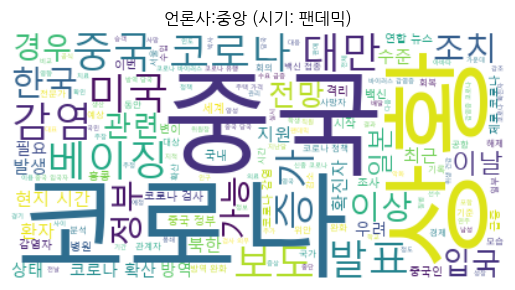

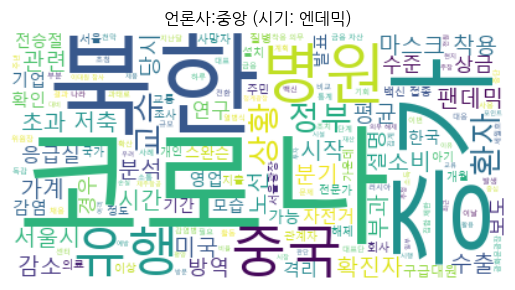

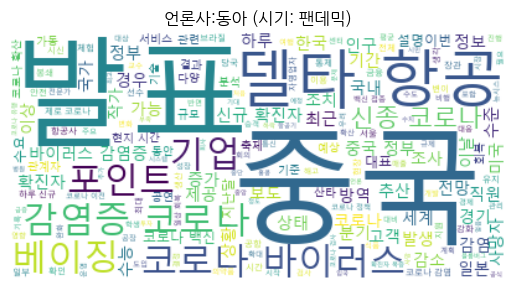

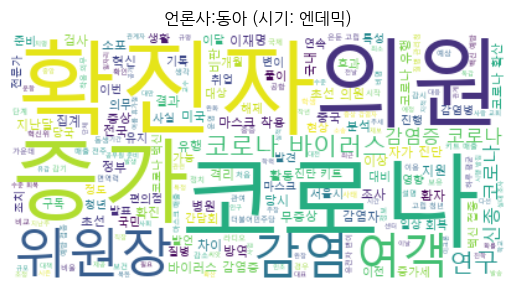

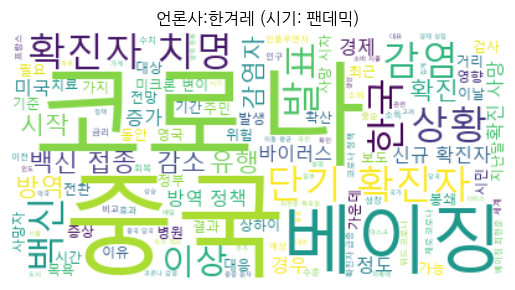

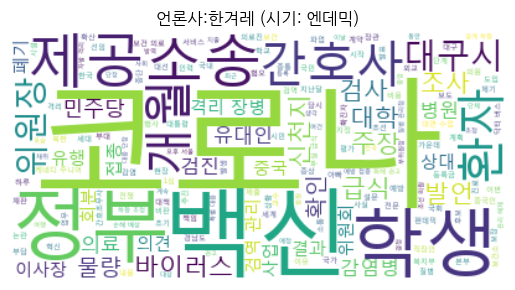

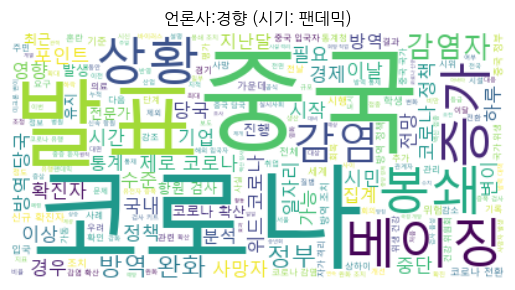

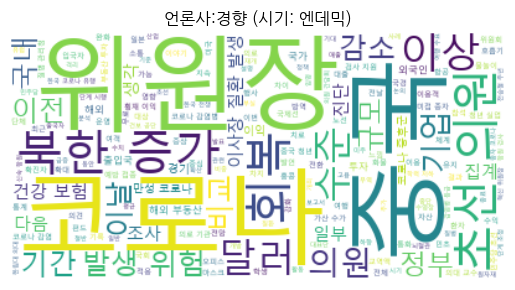

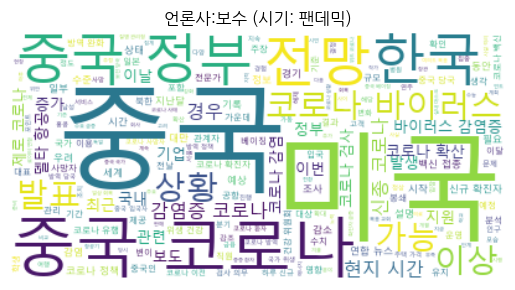

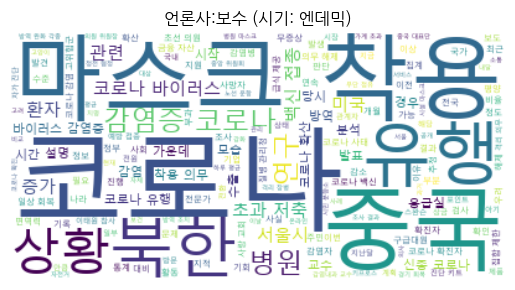

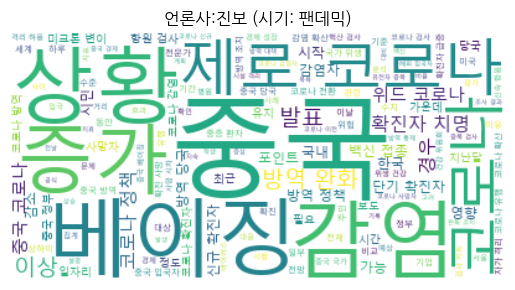

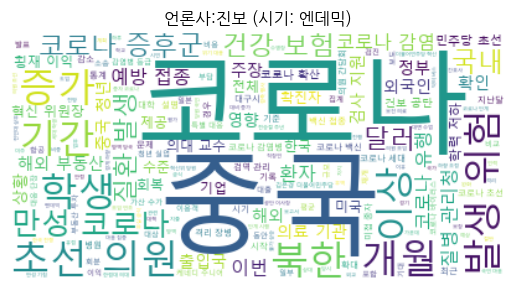

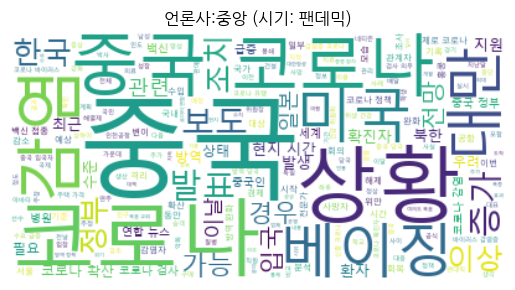

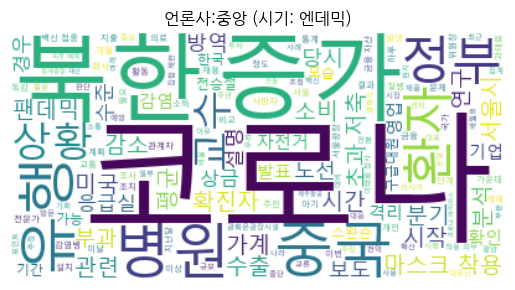

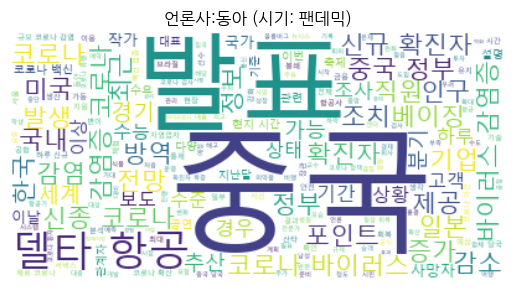

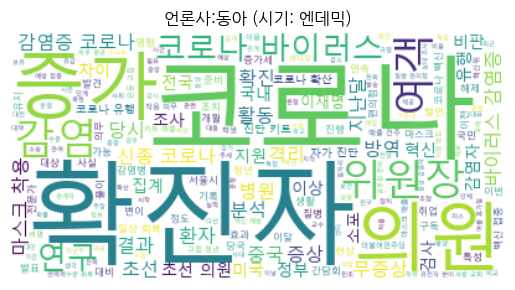

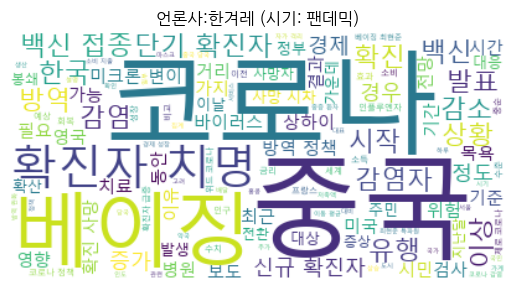

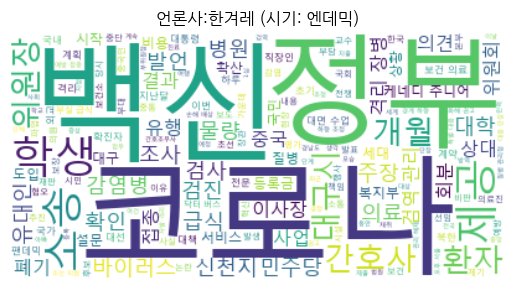

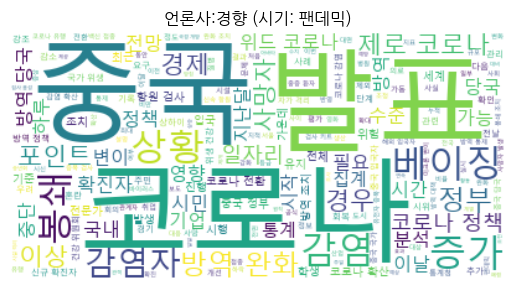

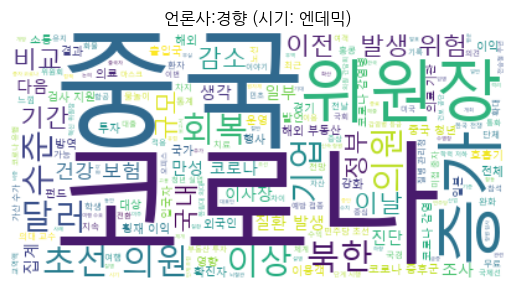

In [64]:
for newspaper, media_string, period in total_list:
    wordcloud(' '.join(media_string), newspaper, period)

# 4. 네트워크 분석


In [45]:

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import networkx as nx
def construct_network(text):
    vectorizer = CountVectorizer(min_df=1, ngram_range=(1,1))
    DTM_tf = vectorizer.fit_transform(text)
    feature_names = vectorizer.get_feature_names_out()
    DTM = np.array(DTM_tf.todense())
    DTM_binary = np.sign(DTM)
    words_cooccurrence = np.dot(DTM_binary.T, DTM_binary)
    np.fill_diagonal(words_cooccurrence, 0)
    #print(feature_names) # 네트워크를 구성하는 단어 출력하기
    #print(words_cooccurrence) # 단어들 간의 인접행렬 출력하기
    g = nx.convert_matrix.from_numpy_array(words_cooccurrence)
    mapping = {}
    for k, word in enumerate(feature_names):
        mapping[k]=word
    g1 = nx.relabel_nodes(g, mapping)
    return g1

In [46]:
def get_text_network(media_list, selected_words):
    cleaned_articles = [preprocessing(article) for article in media_list] # Q> 오류. expected string or bytes-like object, got 'list'
    new_docs=[]
    for article in cleaned_articles:
        new_doc=[]
        for word in article:
            if word in selected_words:
                new_doc.append(word)
        if len(new_doc)>1:
            new_docs.append(' '.join(new_doc))
    return construct_network(new_docs)

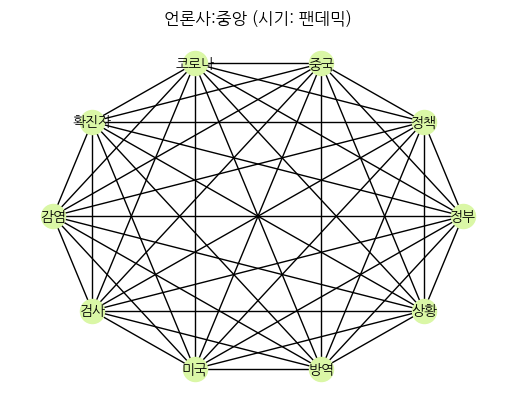

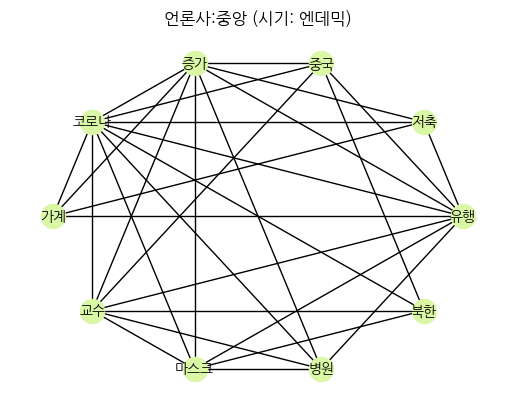

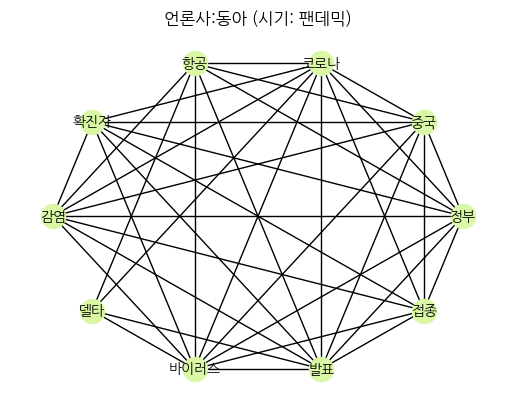

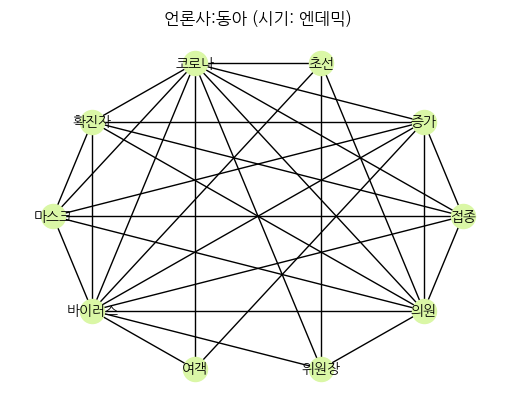

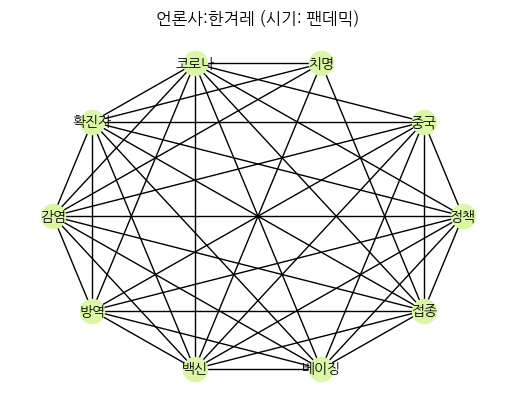

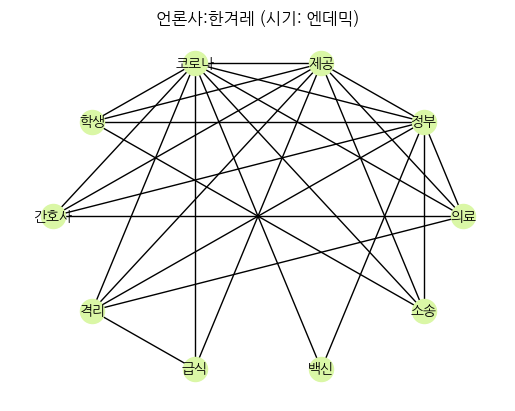

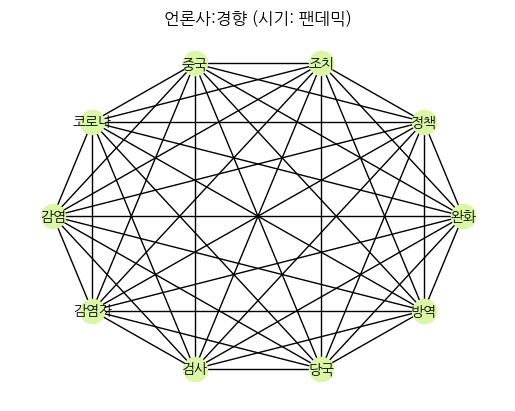

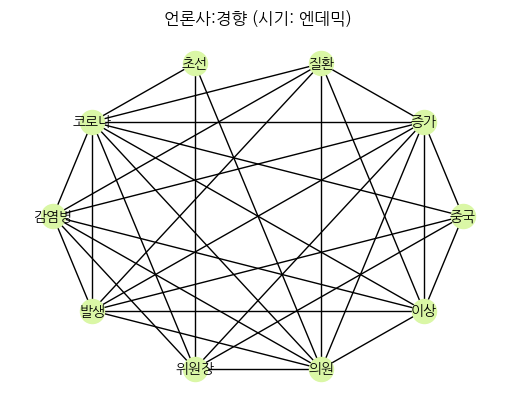

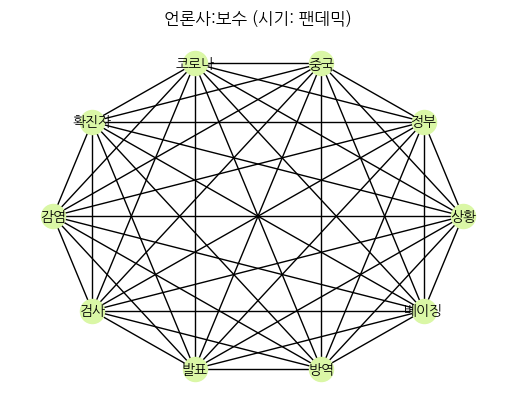

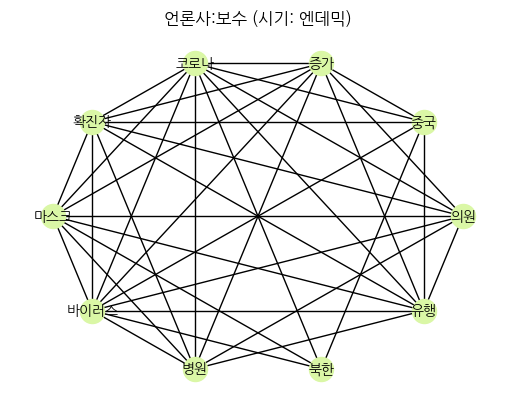

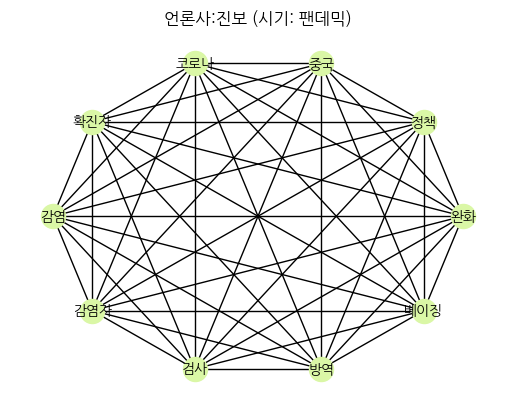

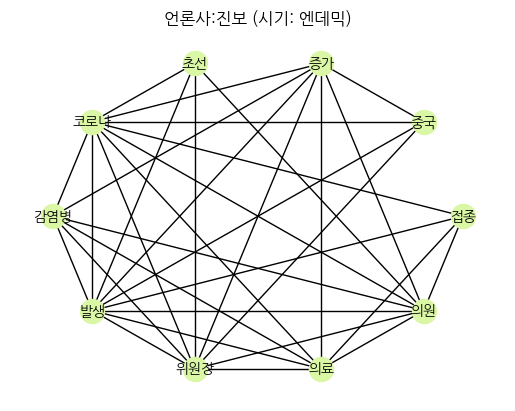

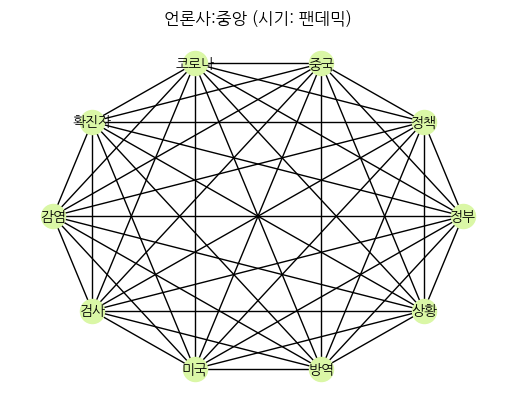

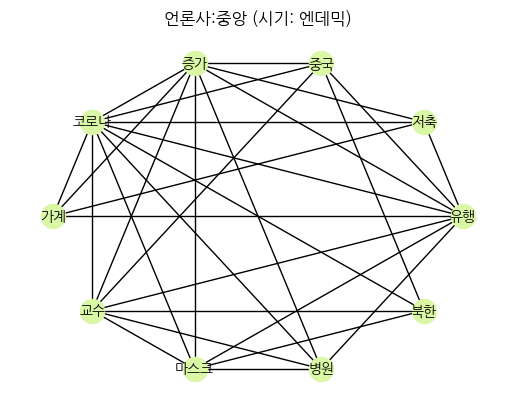

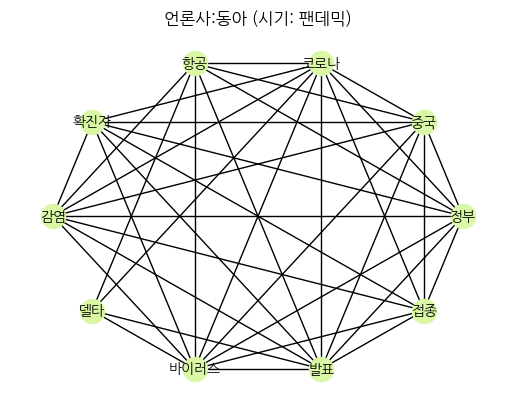

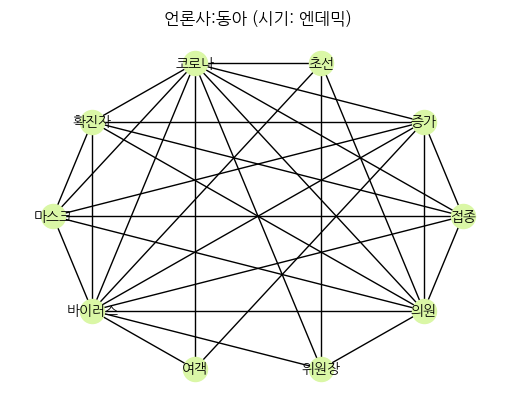

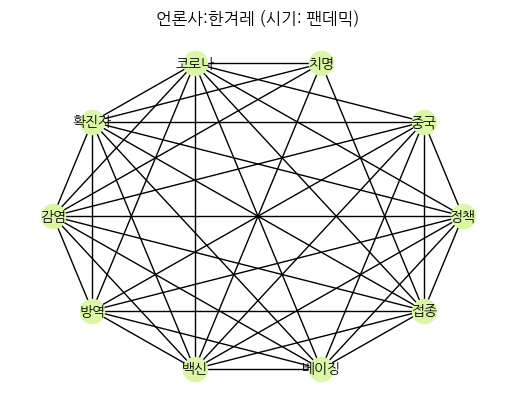

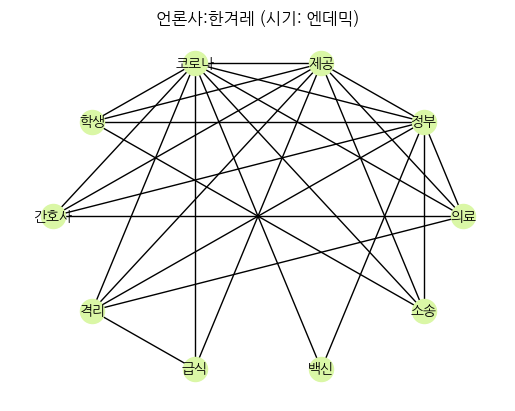

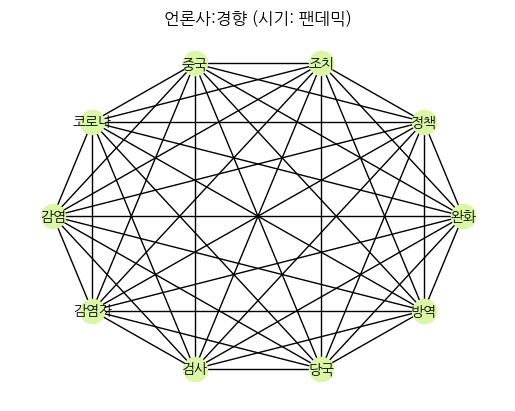

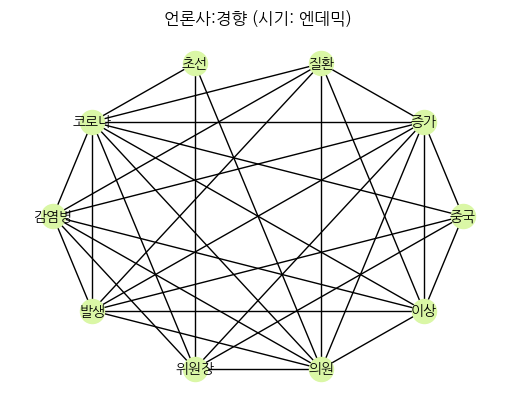

In [65]:
for newspaper, media_string, period in total_list:
    newspaper_en, period_en = ko_to_en_translate_map[newspaper], ko_to_en_translate_map[period]
    nw = get_text_network(media_string, select_words(10, list_to_string(media_string)))
    pos=nx.shell_layout(nw)
    plt.title(f'언론사:{newspaper} (시기: {period})')
    nx.draw_shell(nw,node_color='#DAF7A6')
    nx.draw_networkx_labels(nw,pos,font_family='NanumGothic',font_size=10)
    plt.show()
    nx.write_graphml(nw, f'{newspaper_en}_{period_en}.graphml')